In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('dataset/cleaned/*.txt'))

import unicodedata
import string

import torch
import torch.nn as nn

import random

['dataset/cleaned\\yes.txt', 'dataset/cleaned\\no.txt']


In [3]:
len(string.ascii_letters)

52

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = 200#len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in all_letters
#     )
    return s

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('dataset/cleaned/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
all_categories

['yes', 'no']

In [6]:
print(category_lines['yes'][:5])

['org.elasticsearch.action.percolate.PercolateRequestBuilder.request()__XX__org.elasticsearch.percolator.PercolateRequestBuilder.request()', 'com.squareup.protoparser.ProtoFile.getPackageName()__XX__com.squareup.protoparser.ProtoFile.packageName()', 'org.apache.catalina.deploy.FilterMap.getURLPatterns()__XX__org.apache.tomcat.util.descriptor.web.FilterMap.getURLPatterns()', 'org.mapdb.DB.getTreeSet(String)__XX__org.mapdb.DB.TreeSetMaker', 'com.squareup.protoparser.MessageType.getFields()__XX__com.squareup.protoparser.MessageElement.fields()']


In [7]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 200])


In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128
n_hidden = n_letters
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.7106, -0.6760]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('no', 1)


In [12]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = no / line = org.elasticsearch.action.bulk.BulkItemResponse.isFailed()__XX__org.elasticsearch.common.settings.Setting$AffixKey.match()
category = yes / line = org.rocksdb.Options.setRateLimiterConfig(RateLimiterConfig)__XX__org.rocksdb.Options.setRateLimiter(RateLimiter)
category = no / line = org.elasticsearch.action.search.SearchResponse.getFacets()__XX__org.elasticsearch.common.mvel2.util.ASTLinkedList.reset()
category = no / line = org.apache.tomcat.util.descriptor.web.FilterMap.getFilterName()__XX__org.apache.catalina.session.FileStore.getDirectory()
category = yes / line = com.github.dockerjava.api.model.ContainerConfig.isTty()__XX__com.github.dockerjava.api.model.ContainerConfig.getTty()
category = yes / line = org.apache.sshd.SshServer.setFileSystemFactory(FileSystemFactory)__XX__org.apache.sshd.common.helpers.AbstractFactoryManager.setFileSystemFactory(FileSystemFactory)
category = yes / line = com.google.common.io.Resources.newInputStreamSupplier(URL)__XX__com.googl

In [13]:
criterion = nn.NLLLoss()

In [14]:
learning_rate = 0.0007 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [15]:
import time
import math

n_iters = 15000
print_every = 500
plot_every = 100

In [16]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.7f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 3% (0m 23s) 0.7142559 org.apache.sshd.SshServer.setCommandFactory(CommandFactory)__XX__org.apache.sshd.server.SshServer.setCommandFactory(CommandFactory) / no ✗ (yes)
1000 6% (0m 44s) 0.7025583 org.elasticsearch.common.compress.CompressedXContent.string()__XX__org.elasticsearch.cluster.metadata.MetaData.isExplicitAllType() / yes ✗ (no)
1500 10% (1m 3s) 0.6940420 com.tencent.angel.ml.core.conf.MLConf.ANGEL_ML_TRAIN()__XX__com.tencent.angel.ml.core.conf.AngelMLConf.ANGEL_ML_TRAIN() / no ✗ (yes)
2000 13% (1m 23s) 0.6500241 org.elasticsearch.index.query.MoreLikeThisQueryBuilder.boostTerms(float)__XX__org.elasticsearch.action.admin.cluster.stats.ClusterStatsNodes$NetworkTypes.toXContent() / no ✓
2500 16% (1m 44s) 0.6392772 org.elasticsearch.index.query.RangeQueryBuilder.gte(Object)__XX__org.elasticsearch.cluster.metadata.RepositoryMetaData() / no ✓
3000 20% (2m 7s) 0.6083290 org.apache.tomcat.util.descriptor.web.FilterMap.addServletName(String)__XX__org.apache.catalina.ssi.ExpressionPar

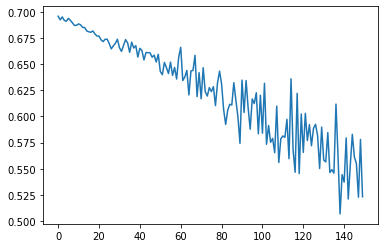

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\mgwei\AppData\Local\Temp/ipykernel_18756/2555472836.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\mgwei\AppData\Local\Temp/ipykernel_18756/2555472836.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


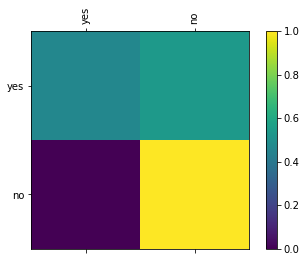

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 500

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [20]:
predict('test')


> test


RuntimeError: selected index k out of range